In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from tools.weaving_tools import NMSCollection, SMGCollection
from pathlib import Path

In [3]:
# nms = NMSCollection(device='mps',img_folder='nms_imgs')
# nms.load_original_csvs(files=list(Path('data').glob('NMS_*.*')))
# nms.save_csv('data/NMS.csv')

/Users/kasparbeelen/Documents/CongruenceEngine/heritage-weaver/tools/weaving_tools.py:355: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(f) for f in files]


In [ ]:
# smg = SMGCollection(device='mps', img_folder='smg_imgs')
# smg.load_from_json('data/smg_objects_06_06_2022.json')
# smg.save_csv('data/SMG.csv')

# Create and Index embeddings

In [29]:
clip_ckpt = 'clip-ViT-B-32'#'openai/clip-vit-base-patch32'

In [30]:
nms = NMSCollection(device='mps',img_folder='nms_imgs')
nms.load_from_csv('data/NMS.csv')
nms.vectorize_collection(clip_ckpt)

Vectorizing image


  0%|          | 0/4794 [00:00<?, ?ex/s]

  0%|          | 0/4794 [00:00<?, ?ex/s]

Vectorizing text


  0%|          | 0/4794 [00:00<?, ?ex/s]

  0%|          | 0/4794 [00:00<?, ?ex/s]

In [55]:
smg = SMGCollection(device='mps',img_folder='smg_imgs')
smg.load_from_csv('data/SMG.csv')

In [56]:
# temp to for testing purposes remove later
#smg.filter_images()
smg.df = smg.df.sample(frac=0.05).reset_index()
smg.df.shape

(15858, 9)

In [57]:
smg.vectorize_collection(clip_ckpt)

Vectorizing image


  0%|          | 0/2286 [00:00<?, ?ex/s]

  0%|          | 0/2286 [00:00<?, ?ex/s]

Vectorizing text


  0%|          | 0/2286 [00:00<?, ?ex/s]

  0%|          | 0/2286 [00:00<?, ?ex/s]

In [ ]:
# smg = SMGCollection(device='mps',img_folder='smg_imgs')
# smg.load_from_csv('data/SMG.csv')
# smg.df = smg.df[smg.df.downloaded==True][:5000].reset_index()
# smg.to_dataset()
# smg.embed_clip(img_target_col,clip_ckpt)

# Create Vector Database

In [58]:
import chromadb

In [65]:
client = chromadb.PersistentClient(path="ce_vector_db")

In [64]:
client.delete_collection(name="congruence_engine")


In [66]:
collection = client.get_or_create_collection(name="congruence_engine")

In [95]:
collection.count()

7080

In [69]:
nms.add_embeddings_to_database(collection,'image')

In [70]:
smg.add_embeddings_to_database(collection,'image')

In [114]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

def plot_images(query_df):
        """plot nearest neighbour images"""
        fig = plt.figure(figsize=(20, 6))
        columns = 3
        rows = 3
        for i in range(1, columns*rows +1):
            
            img = Image.open(query_df.loc[i-1,'img_path'])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
        plt.show()

In [72]:
query_embedding = nms.clip_model.encode('machines')

In [117]:
idx = 3000
query_embedding = np.array(nms.dataset[idx]['clip_image_embedding'])

In [118]:
results = collection.query(
    query_embeddings=[list(query_embedding.astype(float))],
    n_results=10,
    where={"collection": "smg"},
)

In [119]:

query_df = pd.DataFrame(results['metadatas'][0])

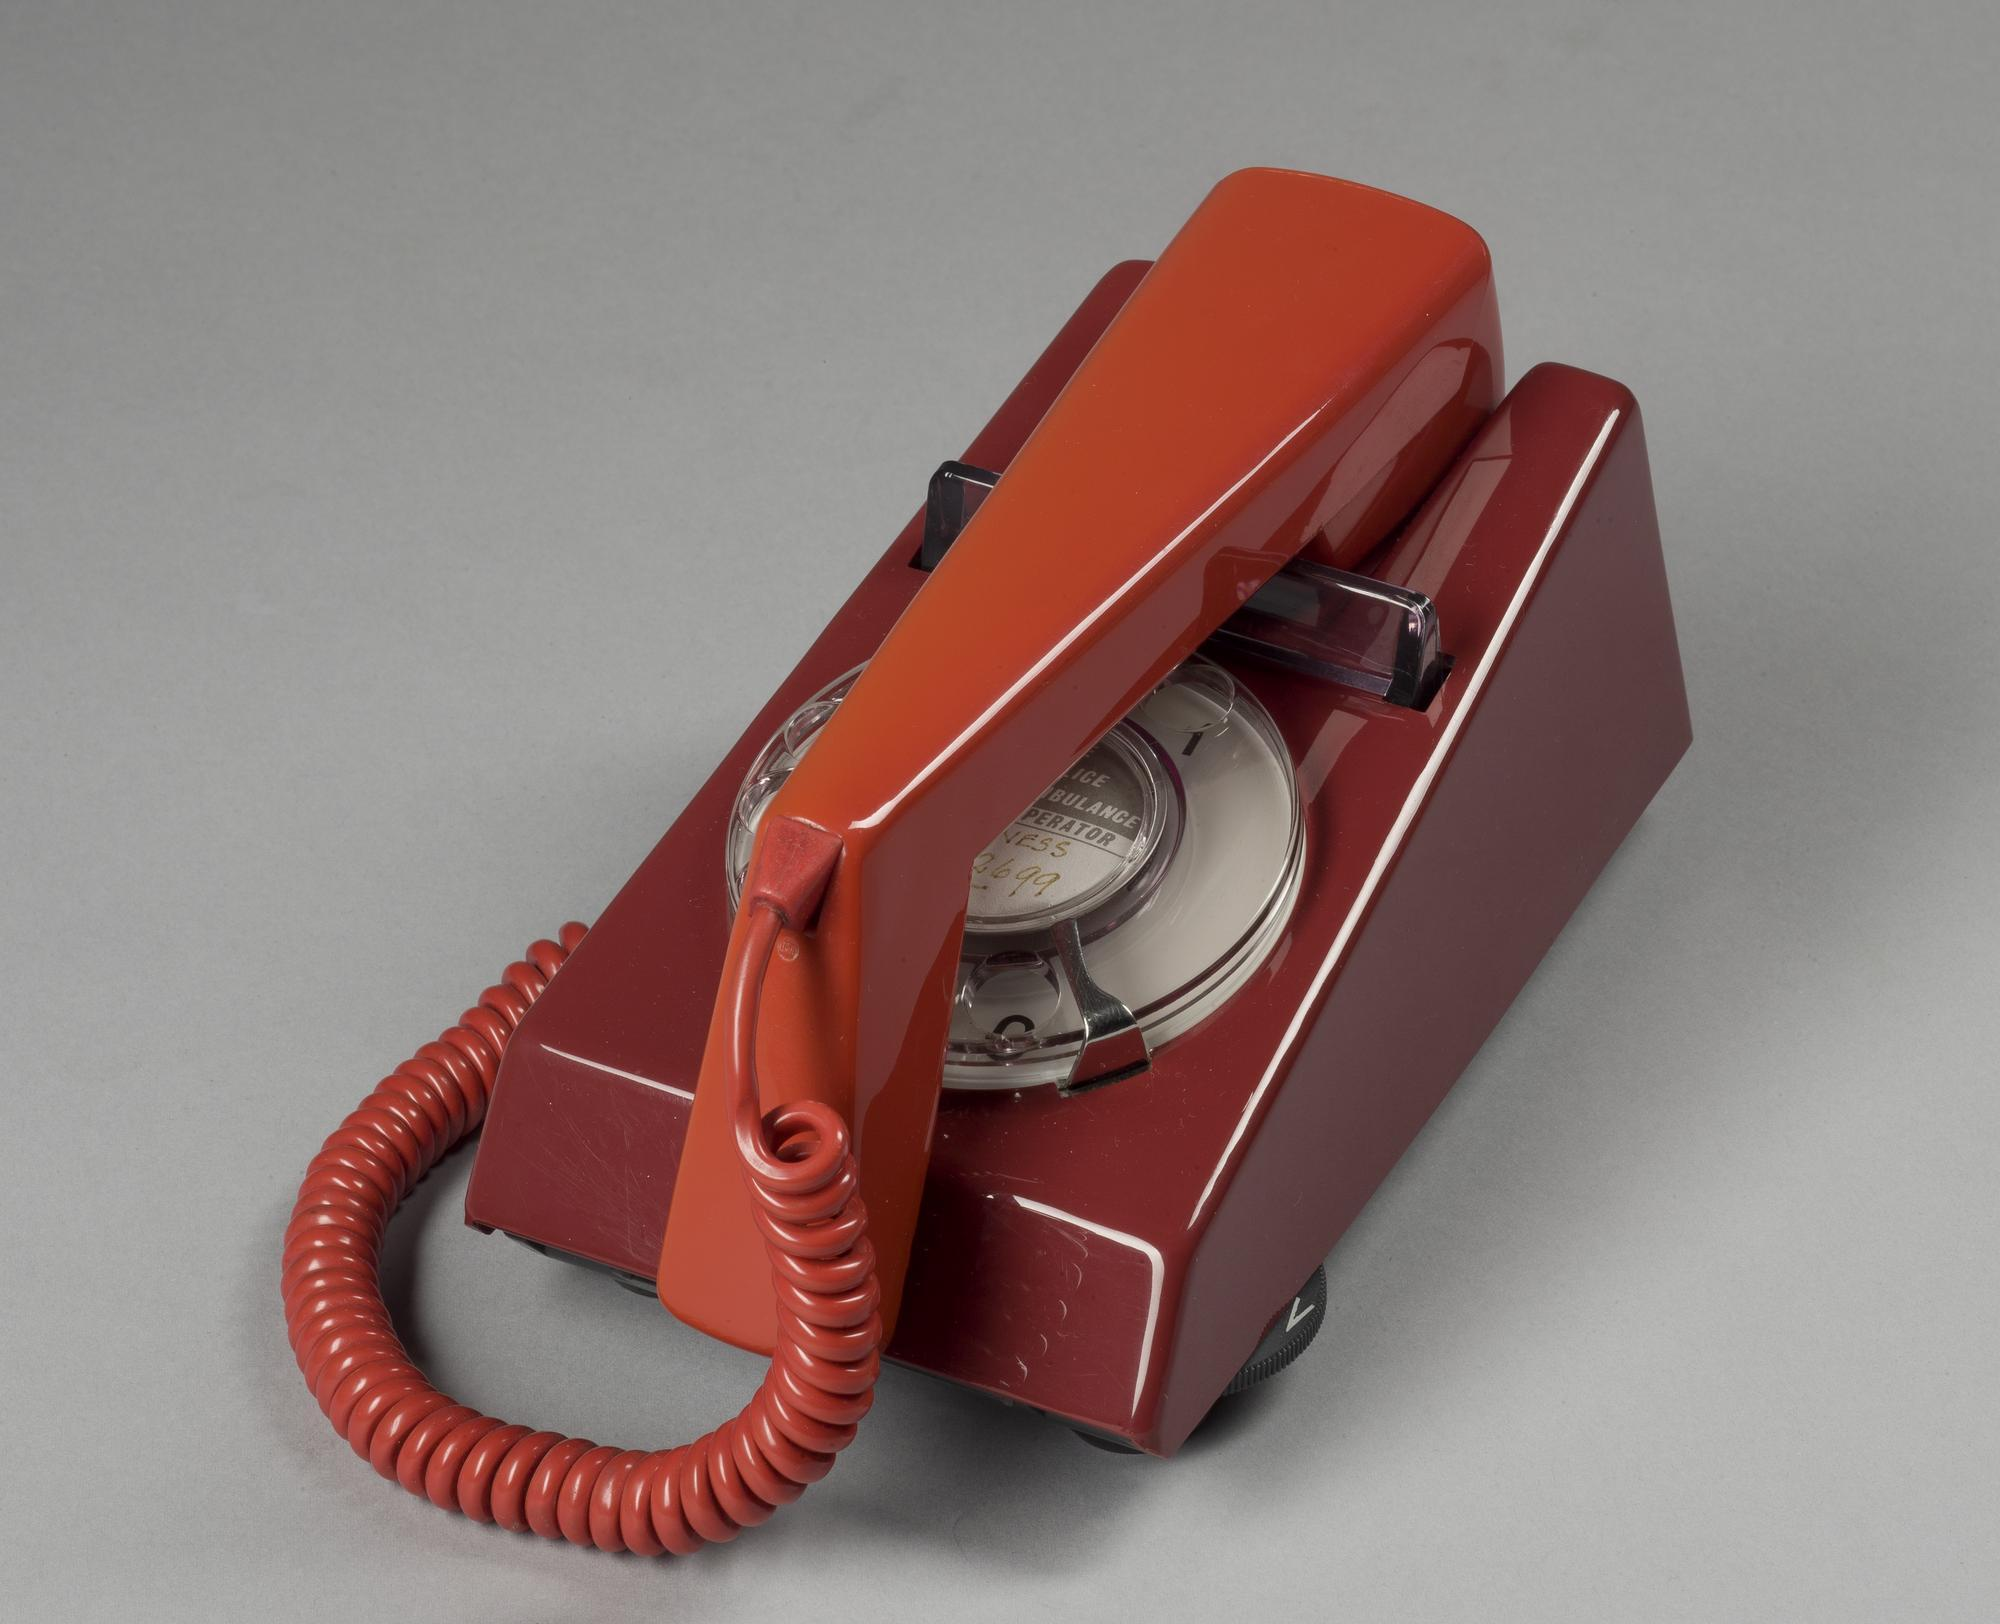

In [120]:
Image.open(nms.dataset[idx]['img_path'])

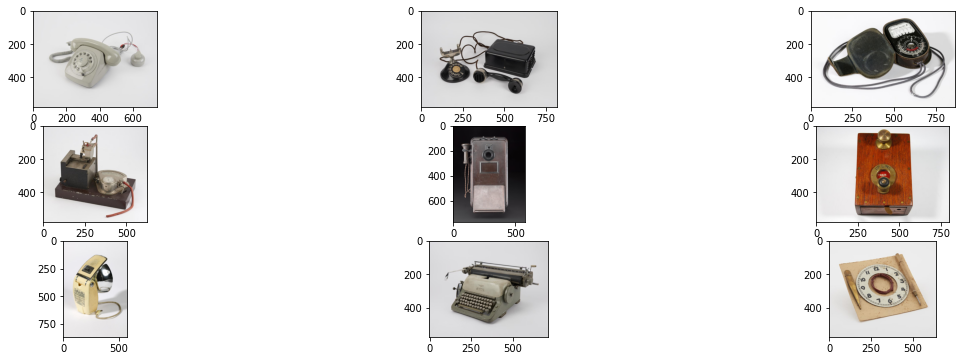

In [121]:
plot_images(query_df)

# Query

In [ ]:
#idx = 10
query = 'instrument'
#query = 'engine'
query_df = nms.query_collection(query, field='clip_embedding', index_type='clip', k=25)
print(query)
nms.plot_images(query_df)

# Zero Shot Classification

In [ ]:
import transformers
transformers.__version__

In [ ]:
#!pip install -U transformers
# old version '4.25.1'

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification
checkpoint = 'openai/clip-vit-base-patch32'
model = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

In [ ]:
from PIL import Image

In [ ]:
idx = 3000#10
image = Image.open(nms.df.iloc[idx].img_path)

In [ ]:
print(nms.df.iloc[idx].taxonomy)

In [ ]:
import re
#pattern = re.compile()
matches = [re.search(r'[A-Z\-\s]+',str(t)) for t in nms.df.taxonomy.unique()]
matches = set([m.group().strip() for m in matches if m])
candidate_labels = list({i for i in matches if len(i) > 1})

In [ ]:
inputs = processor(images=image, text=candidate_labels, return_tensors="pt", padding=True)

In [ ]:
#inputs

In [ ]:
import torch

with torch.no_grad():
    outputs = model(**inputs)
    
logits = outputs.logits_per_image[0]
probs = logits.softmax(dim=-1).numpy()
scores = probs.tolist()

In [ ]:
result = [
    {"score": score, "label": candidate_label}
        for score, candidate_label in sorted(zip(probs, candidate_labels), key=lambda x: -x[0])
]

In [ ]:
result

In [ ]:
import pandas as pd
pd.Series(scores, index=candidate_labels).plot(kind='bar')

In [ ]:
import torch

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits_per_image[0]
probs = logits.softmax(dim=-1).numpy()
scores = probs.tolist()

result = [
    {"score": score, "label": candidate_label}
        for score, candidate_label in sorted(zip(probs, candidate_labels), key=lambda x: -x[0])
]

result

# Nomic Experiment

In [75]:
from nomic import atlas
import numpy as np

In [76]:
%%bash
nomic login pyKINnSOXSivweuAXxprY7j8NtVFI88WC7AeE3BnLAmQZ

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [89]:
nms_clip_embeddigns = np.array(nms.dataset['clip_image_embedding'])
base_url = 'https://www.nms.ac.uk/search.axd?command=getcontent&server=Detail&value='
nms.df['url'] = nms.df.img_loc.apply(lambda x: base_url + x)
nms_data = [{'category': str(row.taxonomy), 'collection':'nms','id': str(i), 'url': row.url}
            for i, row in nms.df.iterrows()]

In [90]:
smg_clip_embeddigns = np.array(smg.dataset['clip_image_embedding'])
base_url = 'https://coimages.sciencemuseumgroup.org.uk/images/'
smg.df['url'] = smg.df.img_loc.apply(lambda x: base_url + x)
smg_data = [{'category': str(row.taxonomy), 'collection':'smg','id': str(i), 'url': row.url}
            for i, row in smg.df.iterrows()]

In [91]:
embeddings = np.concatenate([nms_clip_embeddigns,smg_clip_embeddigns], axis=0)

In [92]:
data = nms_data + smg_data

In [93]:
len(data), len(embeddings)

(7080, 7080)

In [94]:
project = atlas.map_embeddings(embeddings=embeddings,
                                data=data,
                                id_field='id',
                                name='CE Map',
                                colorable_fields=['category','collection'],
                                reset_project_if_exists=True)

2023-09-29 13:02:26.265 | INFO     | nomic.project:__init__:702 - Found existing project `CE Map` in organization `kasparvonbeelen`. Clearing it of data by request.
2023-09-29 13:02:26.986 | INFO     | nomic.project:_create_project:790 - Creating project `CE Map` in organization `kasparvonbeelen`
2023-09-29 13:02:28.054 | INFO     | nomic.atlas:map_embeddings:108 - Uploading embeddings to Atlas.
100%|█████████████████████████████████████████████| 2/2 [00:08<00:00,  4.94s/it]2023-09-29 13:02:37.816 | ERROR    | nomic.project:_add_data:1368 - Shard upload failed: {"detail":"Insert failed due to ID conflict. Conflicting IDs: ['1768', '216', '316', '732', '734', '533', '742', '479', '1406', '2055', '1040', '489', '670', '119', '876', '189', '974', '393', '483', '622', '1880', '1260', '682', '278', '1043', '1680', '1288', '660', '2043', '566', '2179', '1394', '1099', '594', '830', '788', '567', '1160', '1162', '1167', '966', '419', '378', '191', '1995', '1584', '201', '411', '798', '1407', 

100%|█████████████████████████████████████████████| 2/2 [00:09<00:00,  4.85s/it]
2023-09-29 13:02:37.820 | INFO     | nomic.project:_add_data:1422 - Upload succeeded.
2023-09-29 13:02:37.822 | INFO     | nomic.atlas:map_embeddings:127 - Embedding upload succeeded.
2023-09-29 13:02:39.346 | INFO     | nomic.project:create_index:1132 - Created map `CE Map` in project `CE Map`: https://atlas.nomic.ai/map/d290b337-6a74-4878-b638-ed51ada7403c/23f33c4b-0d4b-48ce-b4dd-d7a2310da006
2023-09-29 13:02:39.348 | INFO     | nomic.atlas:map_embeddings:140 - CE Map: https://atlas.nomic.ai/map/d290b337-6a74-4878-b638-ed51ada7403c/23f33c4b-0d4b-48ce-b4dd-d7a2310da006


In [ ]:
nms.df['tax_simpl'] = nms.df.taxonomy.apply(lambda x: re.search(r'[A-Z\-\s]+', str(x)))
nms.df['tax_simpl'] = nms.df['tax_simpl'].apply(lambda x: x.group() if x else 'OTHER')

In [ ]:
clip_embeddigns.shape, len(data)

In [ ]:
print(project)

In [ ]:
dir(nms)

In [ ]:
nms.load_clip_model()

In [ ]:
from transformers import pipeline

captioner = pipeline("image-to-text",model="google/pix2struct-textcaps-base")

In [ ]:

idx = 302
captioner(nms.df.iloc[idx].img_path)

In [ ]:
Image.open(nms.df.iloc[idx].img_path)

In [ ]:
import pandas as pd
from datasets import Dataset, load_dataset
from PIL import Image
import os
df = nms.df.copy()

# Define a function to load images from file paths
def load_image(image_path):
    return Image.open(image_path)

# Apply the image loading function to the DataFrame
df["image"] = df["img_path"]#.apply(load_image)
df.rename({'description':'text'}, axis=1, inplace=True)
# Create a Hugging Face dataset
dataset = Dataset.from_pandas(df[['text','image']])




In [ ]:
dataset

In [ ]:
processor